# Name: Nalet Meinen¶

# Assignment 2 ATML 2020
## Classification with limited data
ImageNet is a well known dataset with 1000 image classes. We will be working on a subset of the dataset (60k images, 100 classes, 600 images per class 80$\times$80 pixels, RGB) and train a model to classify an image into one of the 100 classes. The dataset is located under the "data" directory. Training and validation data splits are under "data/train" and "data/val" directories respectively. Both splits consist of 100 directories, each representing an object category.

In [0]:
import numpy as np
import time
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
!nvidia-smi

Tue Apr 21 19:09:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os.path
if not os.path.isfile('data.zip'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/data.zip" "data.zip"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/datasets.py" "datasets.py"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/task3.pht" "task3.pht"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/ablation1.pht" "ablation1.pht"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/ablation2.pht" "ablation2.pht"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/ablation3.pht" "ablation3.pht"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/ablation4.pht" "ablation4.pht"
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/ablation5.pht" "ablation5.pht"
    !unzip -qq data.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Task 1. Implement ImageNetLimited class for data loading in datasets.py file

In [0]:
from datasets import ImageNetLimited

train_dir = 'data/train'
validation_dir = 'data/val'

_t_mean=[0.485, 0.456, 0.406]
_t_std=[0.229, 0.224, 0.225]

_transforms_train = transforms.Compose([
    transforms.RandomRotation([-45,45]),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

_transforms_val = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

selected_classes = None # [0,1,2,3,4,5,6,7,8,9]

train_dataset = ImageNetLimited(train_dir,_transforms_train,5,selected_classes=selected_classes)
val_dataset = ImageNetLimited(validation_dir,_transforms_val,selected_classes=selected_classes)

print("\n","Train dataset length:",len(train_dataset),"Validation dataset length:",len(val_dataset))

100%|██████████| 29855/29855 [00:14<00:00, 2077.80it/s]


 Train dataset length: 300000 Validation dataset length: 29855


## Task 2. CNN Architecture
Design and implement a Convolutional Neural Network architecture for image classification in a **ConvNet** class in the notebook. Some examples of popular classification models are: AlexNet, VGG, ResNet, ... Justify your design choices in the report. The input to your model must be an image of size $64 \times 64$ pixels.

In [0]:
class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(planes)
            )

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.bn2(self.conv2(output))
        output += self.shortcut(input)
        output = nn.functional.relu(output)
        return output

class ConvNet(nn.Module):

    def __init__(self, num_blocks):
        super(ConvNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, 100)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = nn.functional.avg_pool2d(output, 4)
        output = torch.flatten(output, 1)
        output = self.linear(output)
        return nn.functional.log_softmax(output, dim=1)

In several cases, the ResNet architecture promises good results according to the older AlexNet or VGG. This approach is a more straightforward implementation of ResNet architecture. Notable are the so-called shortcuts, to counter the vanishing gradient problem and allows us to create a deeper network. However, the convolutional network was aligned in the design process to fit the dimensions of the incoming images to train.

Best results, however, were not achieved with a good model, rather than using data augmentation to insert more than one image to the dataset. In this case, the images are added five times, with random rotation between -45° to 45° and a random horizontal flip. Also, the image was not scaled but cropped randomly. The validation set is cropped to the center to not deal with scaling.

## Task 3. Train Model
Implement training and evaluation code for your model. Choose an appropriate loss function and evaluate the model on the validation set using classification accuracy. You are not allowed to use a pre-trained model (must train from scratch on the provided data).<br>
<font color='red'>Your model should achieve an accuracy of at least 40.0% on the validation set (Model with performance smaller than 40.0% will result in 0 points for this task).</font><br>

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, num_blocks, optimizer, loss_fn, n_epochs, **optimizer_params):
    model = ConvNet(num_blocks)
    model = model.to(device)

    optimizer = optimizer(model.parameters(), **optimizer_params)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        time.sleep(0.250) # needed for tqdm
        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))
        time.sleep(0.250)
        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

        best_model = ConvNet(num_blocks)
        best_model = best_model.to(device)
        best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

def test_pretrained(taskname,num_blocks,val_dataloader,loss_fn):
    best_model = ConvNet(num_blocks)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))
    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Model:", taskname, "Average loss:", m_loss, "Accuracy:", accuracy)

def show_validation_errors(taskname,num_blocks,test_loader,num_images=10):
    model = ConvNet(num_blocks)
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(5,5))
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                if(labels.cpu().data[j] == preds[j]):
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    return

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


In [0]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
task3_results = fit("task3", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.02, momentum=0.9, weight_decay=5e-4)
plot_results(task3_results, train_dataloader, val_dataloader)

100%|██████████| 586/586 [08:33<00:00,  1.14it/s]


Epoch 1/10: train_loss: 3.3953, train_accuracy: 17.9707, val_loss: 3.1011, val_accuracy: 23.3060


100%|██████████| 586/586 [08:33<00:00,  1.14it/s]


Epoch 2/10: train_loss: 2.4983, train_accuracy: 34.3513, val_loss: 2.6394, val_accuracy: 32.0482


100%|██████████| 586/586 [08:33<00:00,  1.14it/s]


Epoch 3/10: train_loss: 2.0484, train_accuracy: 44.0567, val_loss: 2.3961, val_accuracy: 37.7726


 38%|███▊      | 223/586 [03:15<05:17,  1.14it/s]

```
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 1/10: train_loss: 3.3827, train_accuracy: 18.1747, val_loss: 3.2366, val_accuracy: 21.9863
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 2/10: train_loss: 2.4880, train_accuracy: 34.5513, val_loss: 2.7087, val_accuracy: 31.2443
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 3/10: train_loss: 2.0406, train_accuracy: 44.3347, val_loss: 2.4829, val_accuracy: 35.7260
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 4/10: train_loss: 1.7187, train_accuracy: 51.9950, val_loss: 2.3534, val_accuracy: 40.8776
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 5/10: train_loss: 1.4569, train_accuracy: 58.5200, val_loss: 2.1933, val_accuracy: 43.4534
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 6/10: train_loss: 1.2216, train_accuracy: 64.6750, val_loss: 2.3093, val_accuracy: 42.0600
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 7/10: train_loss: 0.9990, train_accuracy: 70.5617, val_loss: 2.3303, val_accuracy: 44.1635
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 8/10: train_loss: 0.7894, train_accuracy: 76.6097, val_loss: 2.3411, val_accuracy: 44.9941
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 9/10: train_loss: 0.6063, train_accuracy: 81.9947, val_loss: 2.2746, val_accuracy: 46.6019
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 10/10: train_loss: 0.4450, train_accuracy: 87.0333, val_loss: 2.5251, val_accuracy: 45.2521

Best Epoch: 9 Average loss: 2.2745529918347374 Accuracy: 46.60190922793502
CPU times: user 52min 2s, sys: 36min 59s, total: 1h 29min 2s
Wall time: 1h 29min 12s
```
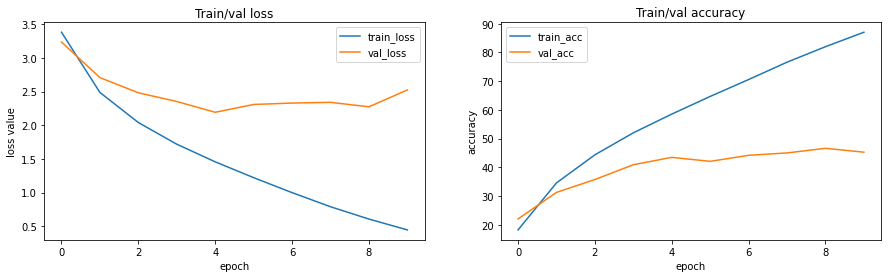

In [0]:
batch_size = 512
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.NLLLoss()
test_pretrained("task3",[2, 2, 2, 2],val_dataloader,loss_fn)

## Task 4. Ablations
Try to find the best performing model by tuning the model design and hyper-parameters on the validation set. Perform ablation experiments to illustrate the effect of the most important hyper-parameters. Some examples of ablations: training parameters (e.g., optimizer, learning rates, batch size), network architecture (e.g., number of layers, number of units, activation function, normalization layers), model regularization (e.g., data augmentation, dropout, weight decay, early stopping), test-time augmentation, etc...  <br>**Perform at least 5 ablations and report the performance of each on the validation set.**

### Ablation 1: Learing Rate

In [0]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
ablation1_results = fit("ablation1", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.01, momentum=0.9, weight_decay=5e-4)
plot_results(ablation1_results, train_dataloader, val_dataloader)


```
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 1/10: train_loss: 3.4289, train_accuracy: 17.4763, val_loss: 3.4627, val_accuracy: 19.6182
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 2/10: train_loss: 2.5646, train_accuracy: 33.1910, val_loss: 2.9903, val_accuracy: 28.4843
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 3/10: train_loss: 2.1293, train_accuracy: 42.5940, val_loss: 2.5724, val_accuracy: 34.7044
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 4/10: train_loss: 1.8186, train_accuracy: 49.8307, val_loss: 2.3890, val_accuracy: 39.7253
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 5/10: train_loss: 1.5534, train_accuracy: 56.1570, val_loss: 2.3144, val_accuracy: 41.0685
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 6/10: train_loss: 1.3203, train_accuracy: 62.1637, val_loss: 2.4730, val_accuracy: 40.1943
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 7/10: train_loss: 1.1076, train_accuracy: 67.7160, val_loss: 2.3182, val_accuracy: 44.0864
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 8/10: train_loss: 0.9059, train_accuracy: 73.2817, val_loss: 2.4149, val_accuracy: 42.8739
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 9/10: train_loss: 0.7210, train_accuracy: 78.7993, val_loss: 2.8253, val_accuracy: 39.1660
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 10/10: train_loss: 0.5542, train_accuracy: 83.7993, val_loss: 2.6147, val_accuracy: 44.3209

Best Epoch: 10 Average loss: 2.61469356084274 Accuracy: 44.320884273990956
CPU times: user 52min 5s, sys: 36min 52s, total: 1h 28min 58s
Wall time: 1h 29min 8s
```
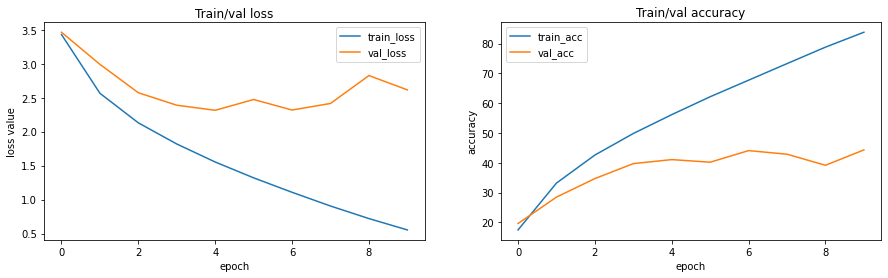

In [0]:
batch_size = 512
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.NLLLoss()
test_pretrained("ablation1", [2, 2, 2, 2], val_dataloader, loss_fn)

The Learning Rate is an essential parameter of Gradient Descent. The rate helps to control the change of weights for our network to the loss of the Gradient Descent. It is one of the most critical parameters. Playing with it can have a significant effect, as seen in this ablation. With the change of the rate by half, the result is different by an even more significant factor. With a false learning rate, we are making wrong steps and can be stuck in local optima or go around it, as shown in this ablation 1.

### Ablation 2: Batch Size

In [0]:
%%time
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
ablation1_results = fit("ablation2", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.02, momentum=0.9, weight_decay=5e-4)
plot_results(ablation1_results, train_dataloader, val_dataloader)

```
100%|██████████| 2344/2344 [09:28<00:00,  4.12it/s]
Epoch 1/10: train_loss: 3.4217, train_accuracy: 17.2677, val_loss: 2.9383, val_accuracy: 25.4966
100%|██████████| 2344/2344 [09:28<00:00,  4.12it/s]
Epoch 2/10: train_loss: 2.4867, train_accuracy: 34.4917, val_loss: 2.5431, val_accuracy: 33.8570
100%|██████████| 2344/2344 [09:28<00:00,  4.12it/s]
Epoch 3/10: train_loss: 2.0017, train_accuracy: 45.2590, val_loss: 2.2349, val_accuracy: 41.4671
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 4/10: train_loss: 1.6719, train_accuracy: 53.0690, val_loss: 2.0572, val_accuracy: 44.3979
100%|██████████| 2344/2344 [09:28<00:00,  4.12it/s]
Epoch 5/10: train_loss: 1.4153, train_accuracy: 59.4793, val_loss: 2.0947, val_accuracy: 45.9421
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 6/10: train_loss: 1.2139, train_accuracy: 64.4983, val_loss: 2.2040, val_accuracy: 45.9086
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 7/10: train_loss: 1.0600, train_accuracy: 68.5977, val_loss: 2.3772, val_accuracy: 44.3544
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 8/10: train_loss: 0.9269, train_accuracy: 72.2870, val_loss: 2.2430, val_accuracy: 47.3288
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 9/10: train_loss: 0.8278, train_accuracy: 74.9723, val_loss: 2.3163, val_accuracy: 46.1397
100%|██████████| 2344/2344 [09:29<00:00,  4.12it/s]
Epoch 10/10: train_loss: 0.7496, train_accuracy: 77.2290, val_loss: 2.2433, val_accuracy: 46.8263

Best Epoch: 8 Average loss: 2.2429840912421546 Accuracy: 47.32875565231954
CPU times: user 1h 4s, sys: 38min 36s, total: 1h 38min 40s
Wall time: 1h 38min 46s
```
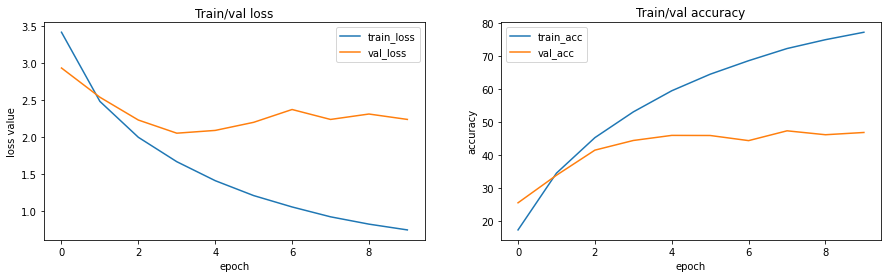


In [0]:
batch_size = 128
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.NLLLoss()
test_pretrained("ablation2", [2, 2, 2, 2], val_dataloader, loss_fn)

The batch size gives us the batch in each iteration the optimizer analyzes. Having a batch size to large can provide us with a too general result. In this case, with smaller batch sizes, the model got more accurate on the validation set.

### Ablation 3: Optimizer

In [0]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.Adam
n_epochs = 10
loss_fn = nn.NLLLoss()
ablation1_results = fit("ablation3", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.001)
plot_results(ablation1_results, train_dataloader, val_dataloader)

```
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 1/10: train_loss: 3.5177, train_accuracy: 15.9277, val_loss: 3.2586, val_accuracy: 20.4890
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 2/10: train_loss: 2.5914, train_accuracy: 32.4087, val_loss: 2.6307, val_accuracy: 32.6009
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 3/10: train_loss: 2.0609, train_accuracy: 43.9397, val_loss: 2.3219, val_accuracy: 40.5862
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 4/10: train_loss: 1.6359, train_accuracy: 53.9043, val_loss: 2.3035, val_accuracy: 42.0834
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 5/10: train_loss: 1.2472, train_accuracy: 63.6703, val_loss: 2.1754, val_accuracy: 45.8282
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 6/10: train_loss: 0.8807, train_accuracy: 73.6373, val_loss: 2.2806, val_accuracy: 47.1479
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 7/10: train_loss: 0.5640, train_accuracy: 82.7793, val_loss: 2.4968, val_accuracy: 46.2134
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 8/10: train_loss: 0.3269, train_accuracy: 90.0900, val_loss: 2.8715, val_accuracy: 46.7225
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 9/10: train_loss: 0.2002, train_accuracy: 93.9607, val_loss: 3.2218, val_accuracy: 45.7109
100%|██████████| 586/586 [08:36<00:00,  1.13it/s]
Epoch 10/10: train_loss: 0.1550, train_accuracy: 95.2487, val_loss: 3.4890, val_accuracy: 45.6238

Best Epoch: 6 Average loss: 2.280582480511423 Accuracy: 47.14788142689667
CPU times: user 52min 35s, sys: 36min 39s, total: 1h 29min 15s
Wall time: 1h 29min 25s
```
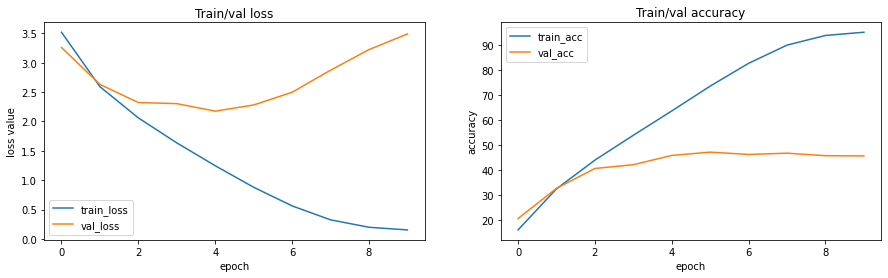

In [0]:
batch_size = 512
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.NLLLoss()
test_pretrained("ablation3", [2, 2, 2, 2], val_dataloader, loss_fn)

The SDG optimizer, combined with Nesterov Momentum, gives us a useful optimizer for our problems. However, SDG optimizer has a fixing learning rate.  Adam implements an adaptive learning rate that helps us to find e better optima. In this case, Adam optimizer has not improved our results. This because SDG with the right momentum is similar.

### Ablation 4: Loss Function

In [0]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.Adam
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()
ablation1_results = fit("ablation4", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.001)
plot_results(ablation1_results, train_dataloader, val_dataloader)

```
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 1/10: train_loss: 3.5416, train_accuracy: 15.5047, val_loss: 3.0083, val_accuracy: 24.1936
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 2/10: train_loss: 2.5900, train_accuracy: 32.3843, val_loss: 2.5074, val_accuracy: 33.6728
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 3/10: train_loss: 2.0617, train_accuracy: 43.7993, val_loss: 2.2624, val_accuracy: 40.8608
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 4/10: train_loss: 1.6358, train_accuracy: 53.8290, val_loss: 2.0269, val_accuracy: 46.2770
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 5/10: train_loss: 1.2541, train_accuracy: 63.5597, val_loss: 2.1273, val_accuracy: 46.9067
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 6/10: train_loss: 0.8888, train_accuracy: 73.4140, val_loss: 2.4319, val_accuracy: 46.5215
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 7/10: train_loss: 0.5653, train_accuracy: 82.7510, val_loss: 2.5952, val_accuracy: 46.6722
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 8/10: train_loss: 0.3305, train_accuracy: 89.9593, val_loss: 2.9601, val_accuracy: 45.5736
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 9/10: train_loss: 0.2046, train_accuracy: 93.8550, val_loss: 3.1716, val_accuracy: 46.3172
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 10/10: train_loss: 0.1605, train_accuracy: 95.0750, val_loss: 3.4650, val_accuracy: 46.2335

Best Epoch: 5 Average loss: 2.127331780175031 Accuracy: 46.9067157929995
CPU times: user 53min 42s, sys: 35min 16s, total: 1h 28min 58s
Wall time: 1h 29min 14s
```
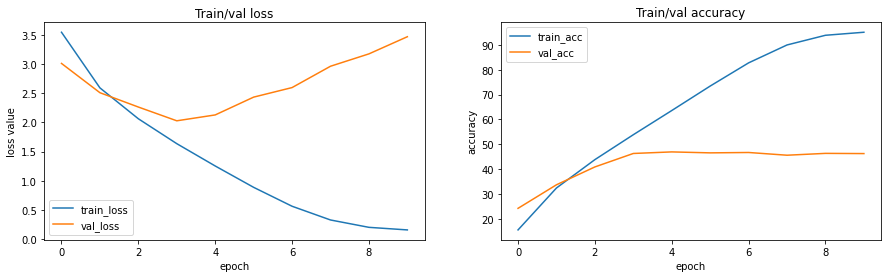

In [0]:
batch_size = 512
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.CrossEntropyLoss()
test_pretrained("ablation4", [2, 2, 2, 2], val_dataloader, loss_fn)

The negative log-likelihood loss maximizes the overall probability of the data. It is suitable for simple tasks and is fast because it uses only a log operation. The cross-entropy loss gives us higher precision as it penalties with a higher value as the negative log-likelihood. Here in these cases, the results are similar. A reason can be very similar images in the validation set.

### Ablation 5: Network Architecture

In [0]:
%%time
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()
ablation1_results = fit("ablation5", train_dataloader, val_dataloader, [2, 3, 4, 2], optimizer, loss_fn, n_epochs, lr=0.02, momentum=0.9, weight_decay=5e-4)
plot_results(ablation1_results, train_dataloader, val_dataloader)

```
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 1/10: train_loss: 3.4508, train_accuracy: 16.8183, val_loss: 2.9583, val_accuracy: 25.1382
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 2/10: train_loss: 2.4853, train_accuracy: 34.3897, val_loss: 2.4403, val_accuracy: 36.0040
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 3/10: train_loss: 2.0001, train_accuracy: 45.2780, val_loss: 2.0834, val_accuracy: 43.7146
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 4/10: train_loss: 1.6721, train_accuracy: 52.9457, val_loss: 2.1352, val_accuracy: 43.7347
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 5/10: train_loss: 1.4202, train_accuracy: 59.2970, val_loss: 2.1017, val_accuracy: 46.5383
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 6/10: train_loss: 1.2132, train_accuracy: 64.6050, val_loss: 2.1180, val_accuracy: 45.5066
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 7/10: train_loss: 1.0530, train_accuracy: 68.8807, val_loss: 2.1129, val_accuracy: 47.7675
100%|██████████| 2344/2344 [12:03<00:00,  3.24it/s]
Epoch 8/10: train_loss: 0.9249, train_accuracy: 72.2857, val_loss: 2.4246, val_accuracy: 44.1769
100%|██████████| 2344/2344 [12:02<00:00,  3.24it/s]
Epoch 9/10: train_loss: 0.8198, train_accuracy: 75.2577, val_loss: 2.2435, val_accuracy: 47.2216
100%|██████████| 2344/2344 [12:02<00:00,  3.24it/s]
Epoch 10/10: train_loss: 0.7427, train_accuracy: 77.3870, val_loss: 2.2224, val_accuracy: 47.7742

Best Epoch: 10 Average loss: 2.2223839515294785 Accuracy: 47.7742421704907
CPU times: user 1h 16min 27s, sys: 49min 8s, total: 2h 5min 36s
Wall time: 2h 5min 42s
```
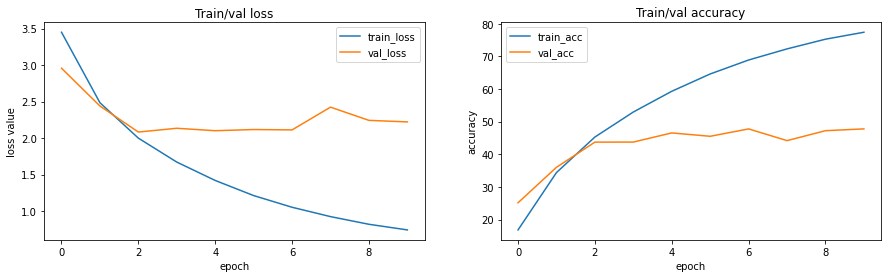

In [0]:
batch_size = 128
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
loss_fn = nn.NLLLoss()
test_pretrained("ablation5", [2, 3, 4, 2], val_dataloader, loss_fn)

Using more residual blocks should increase the complexity of the network and therefore increase the accuracy. With the skip connection implemented, the error should not increase and, thus, should result in a better-trained model. Tn ablation 5, the result was best with a higher complexity model. Therefore, a more complex model and more training time should have given us an even better model. But with higher complexity, the amount of time needed is also more massive as for simpler networks.

## Task 5. Model Errors
Evaluate the trained model on the validation set and plot 10 random mistakes that your model made.

In [0]:
batch_size = 128
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
show_validation_errors("ablation5", [2, 3, 4, 2], val_dataloader, 10)

## Task 6. Competition time!
Read the images from "data/test" folder. There are no labels for these images. Run your best model on these images and save the image IDs (names) and predicted label in a file LastName.csv. You will receive a link via email to upload the CSV file to  an online system which will give you the score of your model on the held-out test set. Top 5 students with at least 40% classification accuracy will obtain bonus points.

In [0]:
import os

paths = []
ids = []
for dirname, _, filenames in os.walk('data/test'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        ids.append(filename.split('.')[0])


_model = ConvNet([2, 3, 4, 2])
_model = _model.to(device)
_model.load_state_dict(torch.load("ablation5.pht"))

_model.eval()

def _predict(path):
    """Returns a randomn prediction"""
    _img = Image.open(path)
    _img = _transforms_val(_img)

    _img = _img.unsqueeze(0)
    _img = _img.to(device)
    output = _model(_img)
    _, preds = torch.max(output, 1)

    return preds[0].cpu().detach().numpy()

predictions = []

for path in tqdm(paths):
    prediction = _predict(path)
    predictions.append(prediction)           

with open('test_results.csv', 'w') as f:
    f.write('id,label\n')
    for id, pred in zip(ids, predictions):
        f.write(f'{id},{pred}\n')